In [59]:
# Import libraries
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For visualizations
from sklearn.model_selection import train_test_split   # For splitting data
from sklearn.linear_model import LogisticRegression     # Logistic Regression model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score  # Model evaluation
import joblib


In [45]:

# Load dataset
df = pd.read_csv("Fraud_Cleaned.csv")  # Ensure the correct file path

# Display basic info
df.info()
df.head()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498050 entries, 0 to 498049
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 498050 non-null  int64  
 1   totalScanTimeInSeconds     498050 non-null  int64  
 2   grandTotal                 498050 non-null  float64
 3   lineItemVoids              498050 non-null  int64  
 4   scansWithoutRegistration   498050 non-null  int64  
 5   quantityModification       498050 non-null  int64  
 6   scannedLineItemsPerSecond  498050 non-null  float64
 7   valuePerSecond             498050 non-null  float64
 8   lineItemVoidsPerPosition   498050 non-null  float64
 9   fraud                      498050 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 MB


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000
mean,3.503243,915.605811,49.996116,5.495896,5.001377,2.499034,0.068059,0.222214,0.735200,0.047634
std,1.707661,528.773256,28.869314,3.447630,3.163808,1.708176,0.521129,1.717987,1.320275,0.212990
min,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000546,0.000005,0.000000,0.000000
25%,2.000000,458.000000,24.940000,3.000000,2.000000,1.000000,0.008682,0.027360,0.161667,0.000000
50%,4.000000,916.000000,50.040000,5.000000,5.000000,2.000000,0.016940,0.054557,0.352941,0.000000
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109102,0.692308,0.000000
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,1.000000


In [61]:
# Data Exploration & Cleaning

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
 trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids                0
scansWithoutRegistration     0
quantityModification         0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
fraud                        0
dtype: int64

Duplicate Rows: 0


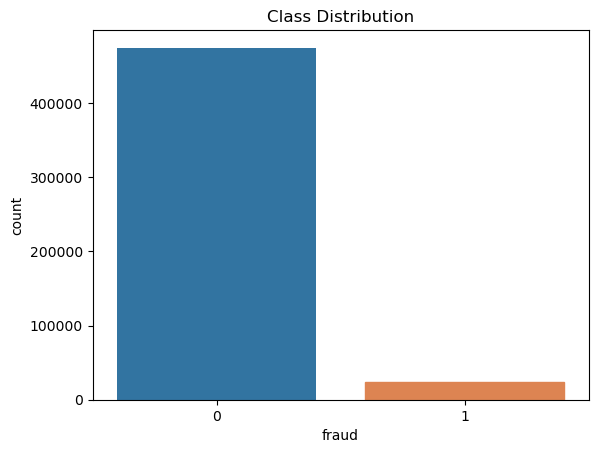

Class distribution (%):
fraud
0    95.236623
1     4.763377
Name: proportion, dtype: float64


In [46]:


# Visualize class distribution with custom color for fraud = 1
ax = sns.countplot(x='fraud', data=df)
ax.patches[1].set_color('#DD8452')  # Set fraud = 1 bar to orange
plt.title('Class Distribution')
plt.show()

# Print class percentages
print("Class distribution (%):")
print(df['fraud'].value_counts(normalize=True) * 100)


The distribution of the target variable fraud is highly imbalanced. The vast majority of transactions are labeled as non-fraudulent (fraud = 0), while only a small fraction are labeled as fraudulent (fraud = 1). Specifically, approximately 95% of the records are non-fraudulent, with only 5% labeled as fraud.

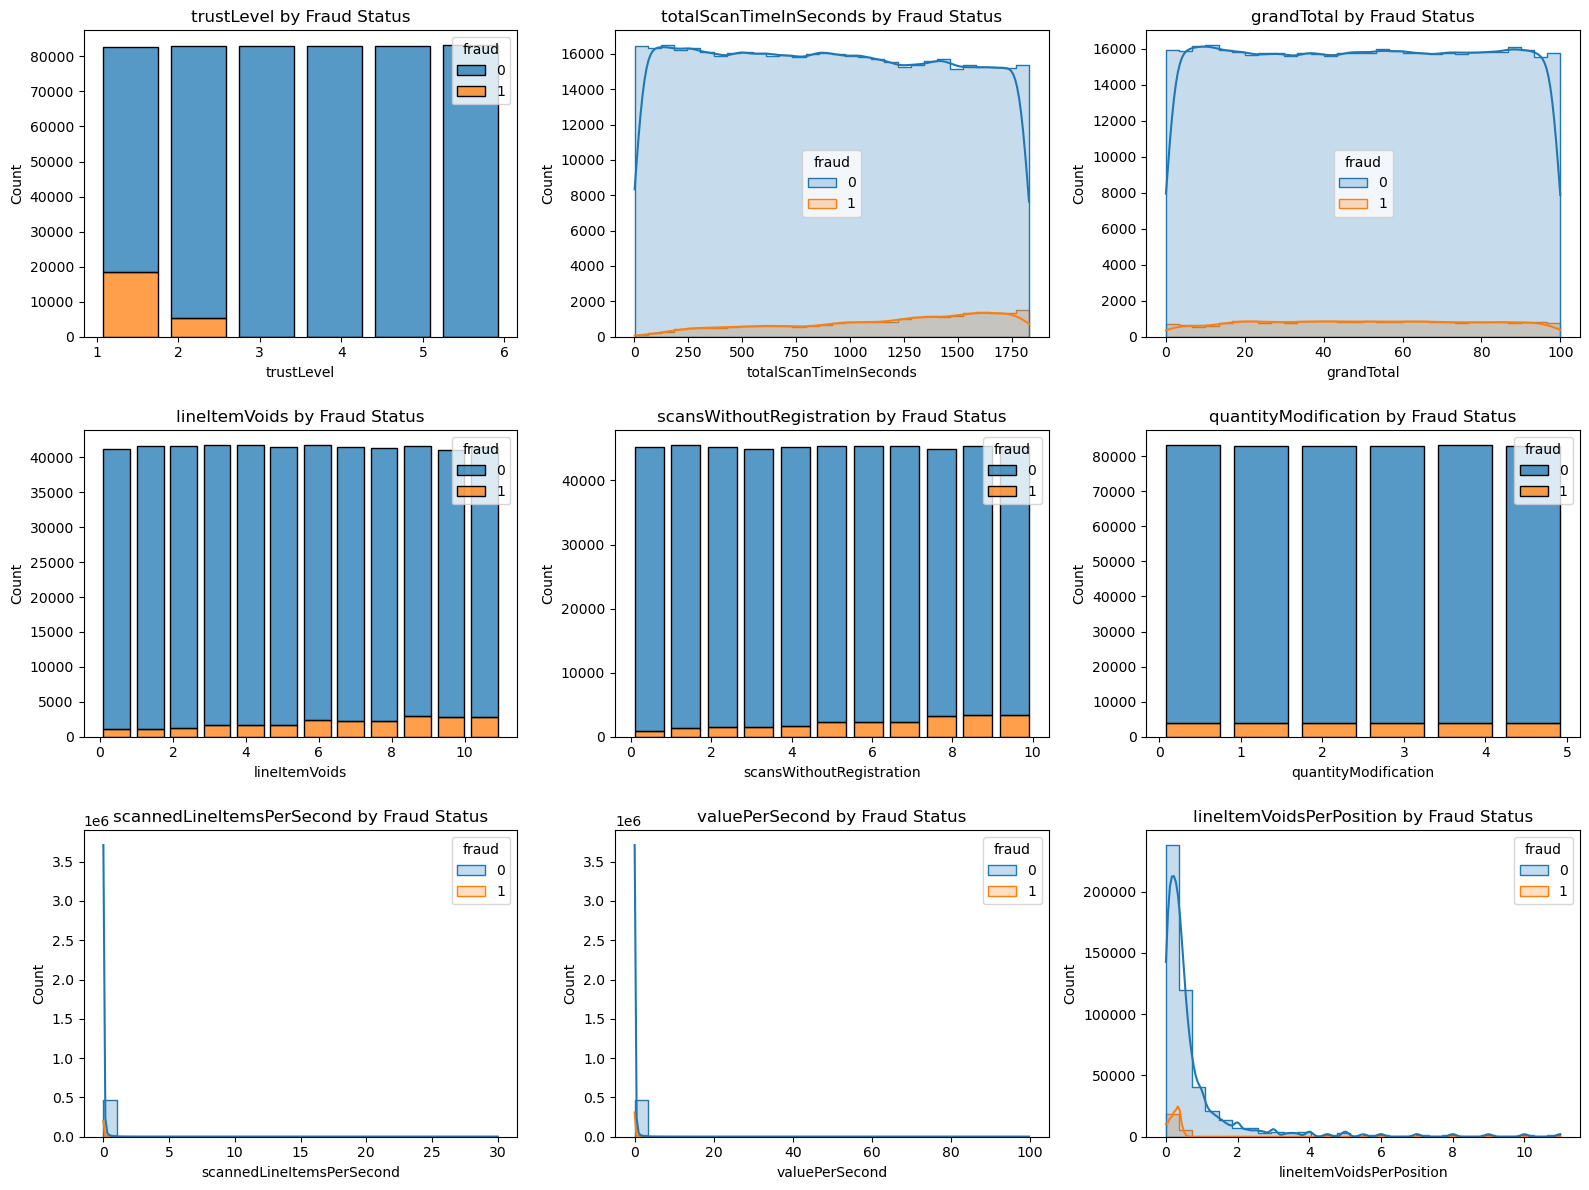

In [47]:

features_to_plot = df.columns.drop("fraud")  # exclude target

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    
    unique_vals = df[feature].nunique()
    
    # Use KDE only for continuous features
    if unique_vals > 20:  # arbitrary threshold;
        sns.histplot(data=df, x=feature, hue="fraud", kde=True, bins=30, element="step")
    else:
        sns.histplot(data=df, x=feature, hue="fraud", kde=False, bins=unique_vals, multiple="stack", shrink=0.8)
    
    plt.title(f"{feature} by Fraud Status")

plt.tight_layout()
plt.show()


The feature trustLevel shows that most non-fraudulent transactions occur at higher trust levels (3–6), while fraud is concentrated at the lowest levels (1 and 2), indicating trust is a strong fraud indicator. totalScanTimeInSeconds and grandTotal display wide distributions with slight elevation in fraud at longer scan durations and higher values, though the separation is not visually distinct. lineItemVoids, scansWithoutRegistration, and quantityModification all show more fraud cases at higher values, supporting their relevance as behavioral indicators of manipulation. In contrast, scannedLineItemsPerSecond and valuePerSecond are extremely skewed, with very few high-value outliers — potentially useful after transformation. Finally, lineItemVoidsPerPosition displays a clear concentration of fraud at higher values, confirming its strong predictive signal. 

In [48]:

# Define the target column
target_col = "fraud"

# Define what qualifies as "low-cardinality"
max_unique = 12
candidate_features = [col for col in df.columns if col != target_col and df[col].nunique() <= max_unique]

# Loop over each low-cardinality feature
for feature in candidate_features:
    summary_rows = []

    for val in sorted(df[feature].unique()):
        total_count = df[df[feature] == val].shape[0]
        count_yes = df[(df[feature] == val) & (df[target_col] == 1)].shape[0]
        count_no = df[(df[feature] == val) & (df[target_col] == 0)].shape[0]
        pct_yes = (count_yes / total_count) * 100 if total_count > 0 else 0
        pct_no = (count_no / total_count) * 100 if total_count > 0 else 0

        summary_rows.append({
            "Value": val,
            "Total Count": total_count,
            "Fraud Count (Yes)": count_yes,
            "Non-Fraud Count (No)": count_no,
            "% Fraud (Yes)": round(pct_yes, 2),
            "% Non-Fraud (No)": round(pct_no, 2),
        })

    summary_df = pd.DataFrame(summary_rows)

    print(f"\n=== Feature: {feature} ===")
    display(summary_df)



=== Feature: trustLevel ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,1,82699,18532,64167,22.41,77.59
1,2,82907,5192,77715,6.26,93.74
2,3,83127,0,83127,0.00,100.00
3,4,82985,0,82985,0.00,100.00
4,5,83036,0,83036,0.00,100.00
5,6,83296,0,83296,0.00,100.00



=== Feature: lineItemVoids ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,41174,1161,40013,2.82,97.18
1,1,41560,1094,40466,2.63,97.37
2,2,41677,1203,40474,2.89,97.11
3,3,41700,1620,40080,3.88,96.12
4,4,41772,1673,40099,4.01,95.99
5,5,41426,1622,39804,3.92,96.08
6,6,41758,2356,39402,5.64,94.36
7,7,41477,2277,39200,5.49,94.51
8,8,41363,2198,39165,5.31,94.69
9,9,41661,2941,38720,7.06,92.94



=== Feature: scansWithoutRegistration ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,45226,944,44282,2.09,97.91
1,1,45547,1428,44119,3.14,96.86
2,2,45221,1435,43786,3.17,96.83
3,3,44952,1564,43388,3.48,96.52
4,4,45248,1635,43613,3.61,96.39
5,5,45324,2250,43074,4.96,95.04
6,6,45324,2290,43034,5.05,94.95
7,7,45385,2286,43099,5.04,94.96
8,8,44968,3226,41742,7.17,92.83
9,9,45454,3348,42106,7.37,92.63



=== Feature: quantityModification ===


,Value,Total Count,Fraud Count (Yes),Non-Fraud Count (No),% Fraud (Yes),% Non-Fraud (No)
0,0,83185,3997,79188,4.80,95.20
1,1,83004,3906,79098,4.71,95.29
2,2,82888,4024,78864,4.85,95.15
3,3,82888,3896,78992,4.70,95.30
4,4,83225,3936,79289,4.73,95.27
5,5,82860,3965,78895,4.79,95.21


## trustLevel
The distribution clearly shows that fraud occurs only at the lowest trust levels (1 and 2), with 22.41% and 6.26% fraud rates respectively. From trust level 3 onward, no fraud is recorded, and all transactions are non-fraudulent. This makes trustLevel one of the strongest features in distinguishing between fraudulent and non-fraudulent behavior — the lower the trust level, the higher the risk.

## lineItemVoids
Fraud percentage increases gradually as the number of voided items increases. For example, fraud rates grow from ~2.6% at 1 void to 6.68% at 11 voids. This steady climb suggests that frequent voiding of items is a clear fraud indicator, and the model should weigh this feature accordingly.

## scansWithoutRegistration
This feature also displays a positive correlation with fraud likelihood. The fraud rate rises from 2.09% at 0 attempts to over 7% at 10 attempts. This supports the idea that customers who repeatedly scan without registering items are exhibiting suspicious behavior, making this another strong behavioral predictor of fraud.

## quantityModification
Fraud rates across different quantity modification values (0–5) are quite stable, hovering between 4.7% and 4.85%. This lack of variation suggests that quantityModification does not strongly differentiate between fraud and non-fraud cases. It may be less valuable as a standalone feature but could still support other interactions in the model.



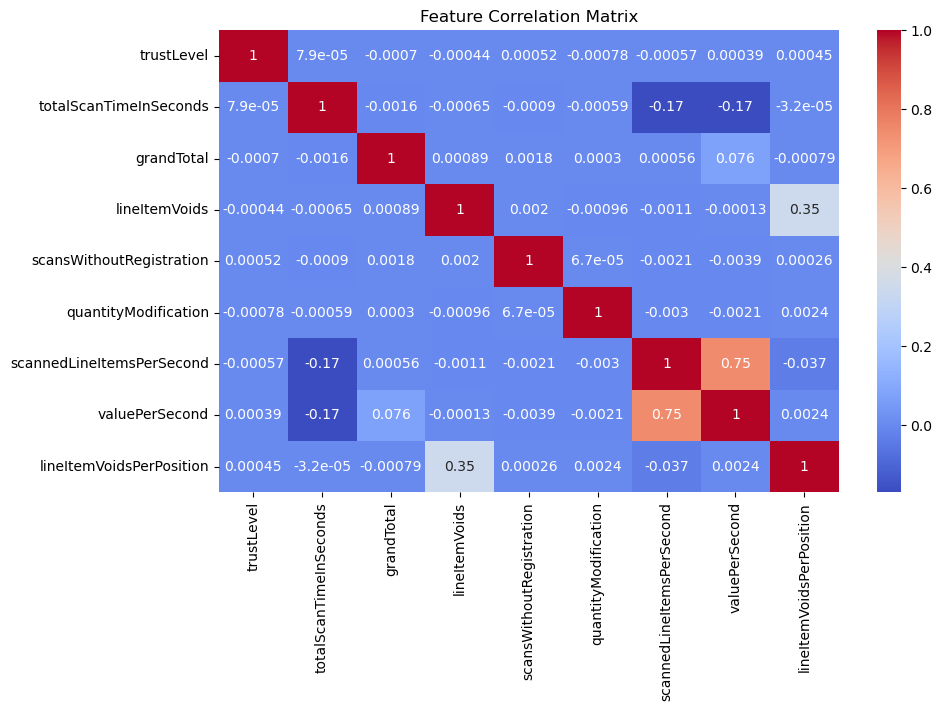

In [49]:
# Visualize feature correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

The correlation matrix analysis confirmed that most features are weakly correlated, minimizing the risk of multicollinearity in the logistic regression model. The only notable exception is the strong correlation (0.75) between scannedLineItemsPerSecond and valuePerSecond, which aligns with domain logic. While both features are retained for now to preserve model performance, they may be revisited during feature importance or model refinement steps. Overall, the selected features appear well-suited for modeling, requiring no immediate removals or transformations.

Missing Values:
 trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids                0
scansWithoutRegistration     0
quantityModification         0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
fraud                        0
dtype: int64

Duplicate Rows: 0


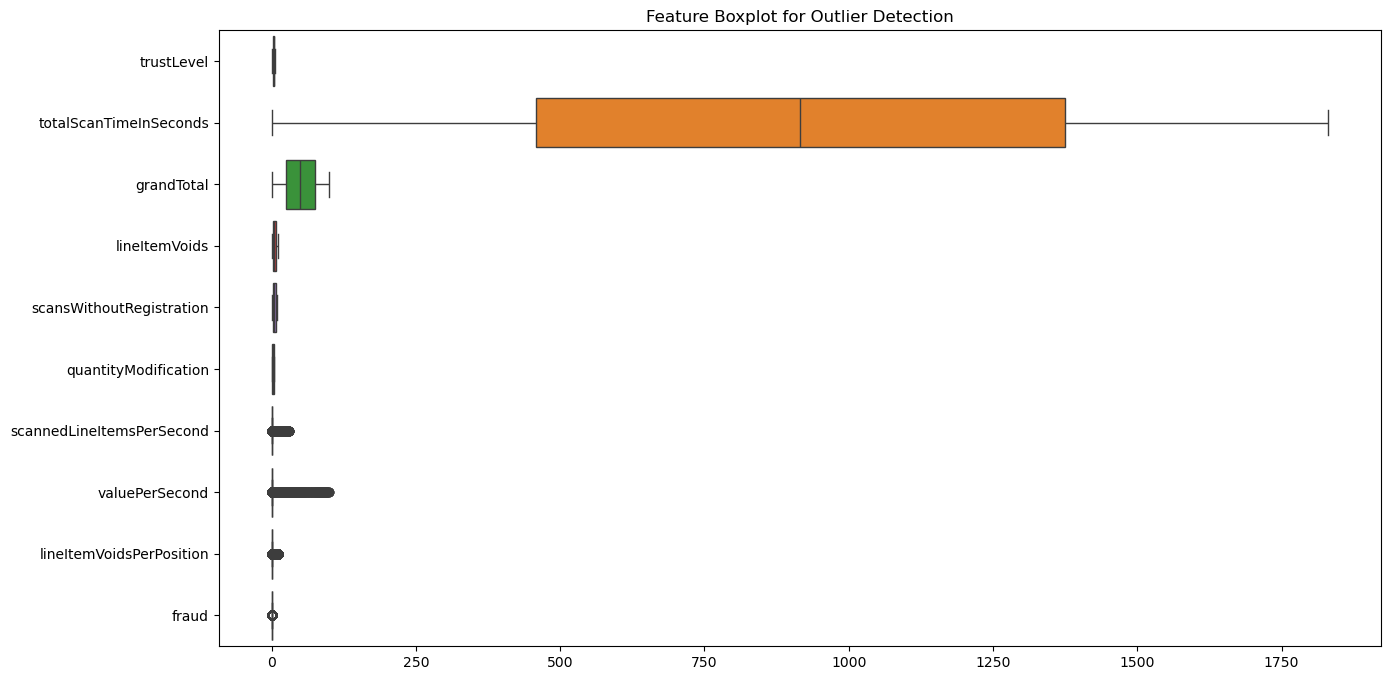

In [50]:


# Visualize outliers using boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h")
plt.title("Feature Boxplot for Outlier Detection")
plt.show()


The boxplot visualizes the distribution and outliers across all features in the dataset. It reveals that most features, such as trustLevel, lineItemVoids, quantityModification, and scansWithoutRegistration, are tightly distributed with limited spread and numerous low-value entries. In contrast, totalScanTimeInSeconds and grandTotal show a wider spread and contain clear outliers, with totalScanTimeInSeconds extending well beyond 1500 seconds, indicating unusually long scanning sessions. Features like valuePerSecond and scannedLineItemsPerSecond are heavily skewed and exhibit extreme outliers, suggesting the need for normalization or transformation prior to modeling. The boxplot effectively highlights which features may require special handling to mitigate the influence of outliers on model performance.

In [51]:


#  Feature & Target Separation 
X = df.drop('fraud', axis=1)
y = df['fraud']

#  70/15/15 Split 
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

#  Feature Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#  Grid Search for Best C, Prioritize Precision 
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid, cv=5, scoring='precision'
)
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_["C"]
print(f"Best C parameter: {best_C}")

Best C parameter: 100


Accuracy: 0.9558
Precision: 0.5187
Recall: 0.9882
F1-score: 0.6803
ROC-AUC: 0.9944
False Positives: 3263, False Negatives: 42
total Cost: 16357


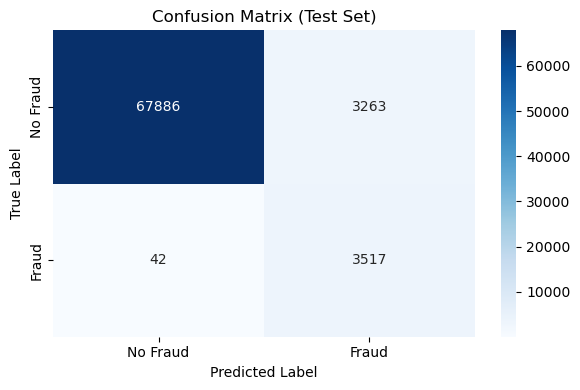

In [52]:
# Initialize and train Logistic Regression model with scaling and convergence fix
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Probability-based ROC AUC

# Confusion matrix + total cost
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
total_cost = (fp * 5) + fn

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"False Positives: {fp}, False Negatives: {fn}")
print(f"total Cost: {total_cost}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Fraud", "Fraud"],
    yticklabels=["No Fraud", "Fraud"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


The logistic regression model achieved a strong overall performance with an accuracy of 95.58% and an excellent ROC-AUC score of 0.9944, indicating a high ability to distinguish between fraud and non-fraud cases. The recall for fraud detection is particularly high at 98.82%, meaning the model successfully identifies the vast majority of fraudulent transactions. However, the precision is relatively low at 51.87%, reflecting a high number of false positives — specifically, 3,263 non-fraud cases were incorrectly flagged as fraud. This imbalance results in a total cost of 16,357, based on the business rule that false positives are five times more costly than false negatives. While the model is highly effective at detecting fraud, it does not align with the cost-sensitive objective, and therefore, further threshold tuning or model refinement is needed to reduce unnecessary false alerts and optimize cost efficiency

In [53]:

# Define threshold range
thresholds = np.round(np.arange(0.01, 0.9995, 0.0005), 4)

# Create empty lists for each metric
all_thresholds = []
all_costs = []
all_fps = []
all_fns = []
all_precisions = []
all_fprs = []

# Loop through thresholds
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    cost = (fp * 5) + fn

    all_thresholds.append(t)
    all_costs.append(cost)
    all_fps.append(fp)
    all_fns.append(fn)
    all_precisions.append(precision)
    all_fprs.append(fpr)

# Create results DataFrame
df_results = pd.DataFrame({
    "Threshold": all_thresholds,
    "Total Cost": all_costs,
    "FP": all_fps,
    "FN": all_fns,
    "Precision": all_precisions,
    "FPR": all_fprs
})

# Identify best threshold (lowest cost)
best_row = df_results.loc[df_results["Total Cost"].idxmin()]
best_thresh = best_row["Threshold"]

# Print best results
print(f"\n Best Threshold: {best_thresh:.4f}")
print(f"Total Cost: {best_row['Total Cost']:.2f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"False Positives: {best_row['FP']}, False Negatives: {best_row['FN']}")



 Best Threshold: 0.9955
Total Cost: 2208.00
Precision: 0.9622
False Positives: 66.0, False Negatives: 1878.0


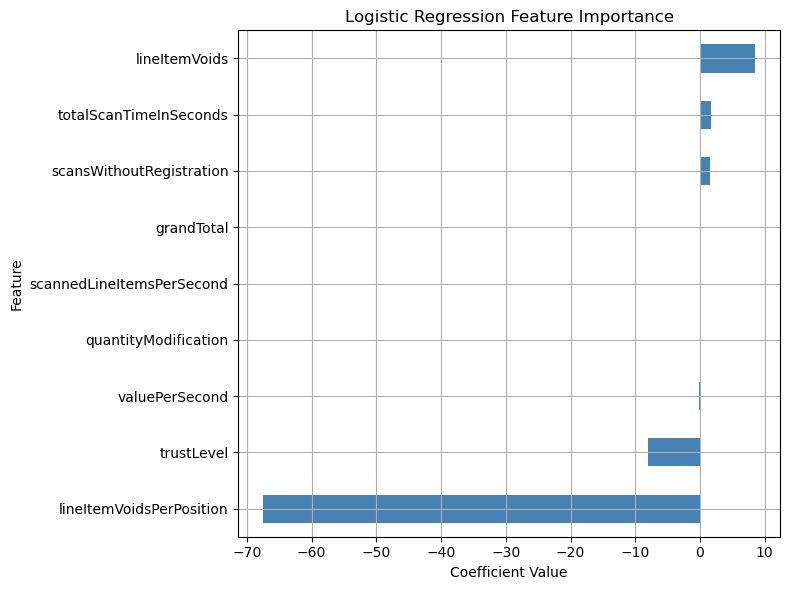

In [54]:
#  Feature Importance 
importance = pd.Series(model.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh', figsize=(8, 6), color="steelblue")
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


The logistic regression coefficient plot shows that "lineItemVoidsPerPosition" has the strongest influence on predicting fraud, with a very large negative weight. Other impactful features include "lineItemVoids" and "trustLevel". Several features such as "grandTotal", "valuePerSecond", and "quantityModification" have near-zero coefficients, indicating minimal contribution to the model. 

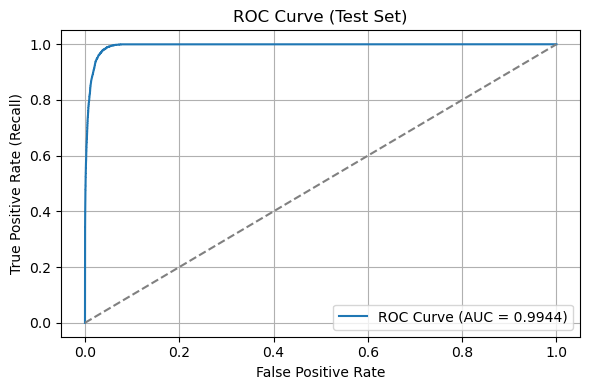

In [55]:
# ROC Curve 
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve demonstrates that the logistic regression model has strong discriminative ability, achieving an AUC of 0.9944. This indicates the model can distinguish fraudulent from non-fraudulent transactions with high reliability across all threshold values. The curve’s position near the top-left corner also reflects the model’s ability to achieve high recall while keeping false positive rates low — supporting its suitability for a cost-sensitive fraud detection context.

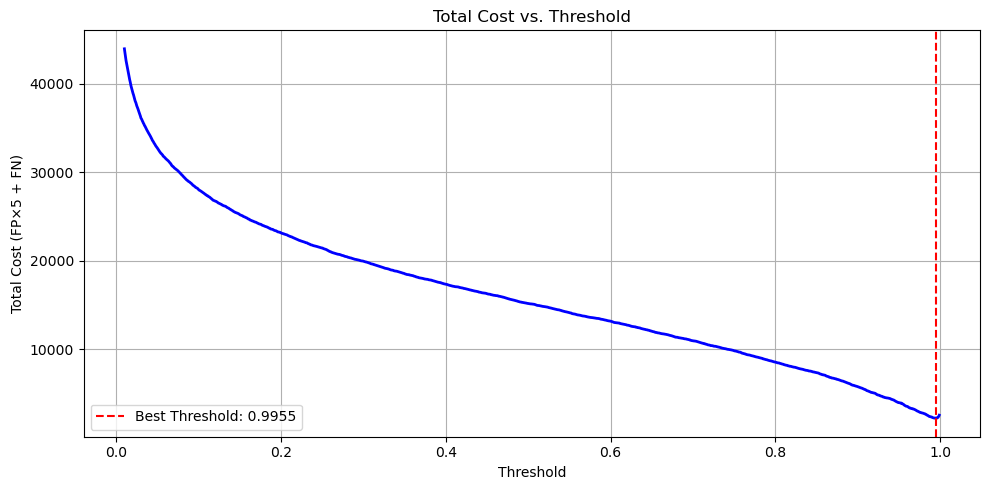

In [56]:
# Plot total cost vs. threshold
plt.figure(figsize=(10, 5))
plt.plot(df_results["Threshold"], df_results["Total Cost"], marker='', color='blue', lw=2)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold: {best_thresh:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Total Cost (FP×5 + FN)")
plt.title("Total Cost vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The "Total Cost vs. Threshold" plot shows how different classification thresholds impact the total business cost, calculated using the custom cost function where false positives are five times more expensive than false negatives. As the threshold increases, the total cost steadily decreases, highlighting that fewer false positives significantly reduce financial impact. The optimal threshold of 0.9955 is marked with a red dashed line, representing the point where the total cost reaches its minimum of 2,208. This threshold offers the best trade-off between minimizing costly false positives and still detecting a meaningful number of fraud cases.

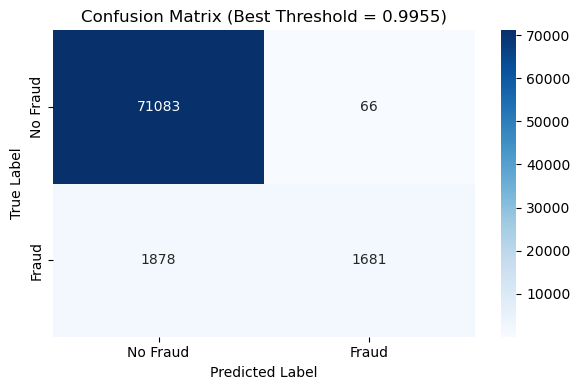

In [57]:
# Plot confusion matrix at best threshold
y_best_pred = (y_prob >= best_thresh).astype(int)
cm_best = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fraud", "Fraud"],
            yticklabels=["No Fraud", "Fraud"])
plt.title(f"Confusion Matrix (Best Threshold = {best_thresh:.4f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The confusion matrix corresponding to the best threshold of 0.9955 reveals the model's performance in absolute terms. Out of all non-fraudulent cases, only 66 were incorrectly classified as fraud (false positives), achieving a precision of 96.22% and a false positive rate of just 0.09%. However, this comes at the expense of recall, as 1,878 fraud cases were missed (false negatives). Still, this threshold aligns with the business objective by significantly reducing high-cost false alarms while maintaining reasonable fraud detection.

In [60]:
# Final threshold based on analysis
final_threshold = 0.9955

# Save the trained model and scaler
joblib.dump(model, "fraud_detection_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(f" Model and scaler saved successfully! Threshold = {final_threshold}")

# Load model & scaler (for prediction/testing)
loaded_model = joblib.load("fraud_detection_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

✅ Model and scaler saved successfully! Threshold = 0.9955
